# 5조 DACON 병원 개폐업 예측 프로젝트 진행방향 :   
## 1. 병원 데이터 중 하나라도 NaN이 있는 row를 모두 제거
## 2. column 중 종속변수에 해당하는 값(당기순이익, 유동자산, 부채총계, 순자산총계) 사용하지 않음  
## 3. 1, 2의 과정을 거친 학습 데이터에 의사결정 나무 알고리즘을 적용
## 4. 테스트 데이터 파일을 불러와 3의 데이터를 바탕으로 개폐업 예측

### 1. train.csv 데이터로 학습

In [1]:
# 필요한 모듈 전부 불러오기
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 글자 깨짐 방지, 천의 자리수 구분 삭제(그러나 성분이 전부 문자열 형태라 효과는 없었음)
train=pd.read_csv("train.csv",sep=",",dtype='unicode',thousands = ',') 
plt.rc('font',family='Malgun Gothic') # 한글 폰트 지원

train

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,open,choongnam,73,20071228,175,nursing_hospital,4217530010,0,3961134739,...,758993742,222876855,0,536116887,3.90E+08,2619290493,1271224493,62,64,same
1,3,open,gyeongnam,32,19970401,410,general_hospital,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,801,813,same
2,4,open,gyeonggi,89,20161228,468,nursing_hospital,1004521989,515483669,447219722,...,0,0,0,0,0,0,0,234,1,same
3,7,open,incheon,141,20000814,353,general_hospital,72507342181,0,70677397660,...,37755010512,17018596586,9219427379,20736413926,1.51E+10,12954271998,7740829037,663,663,same
4,9,open,gyeongnam,32,20050901,196,general_hospital,49043538016,0,47656051197,...,51432592890,30072585842,17593752360,21360007048,14108027465,5561941,9025549604,206,197,same
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,422,open,jeonnam,178,20050211,214,nursing_hospital,7614696536,415347464,5903119133,...,9423771130,2618201328,0,6805569802,5.93E+09,5379501732,811641602,193,141,same
297,423,close,choongnam,159,20140618,NaN,hospital,6717143911,8.20E+09,0,...,0,0,0,0,0,0,0,79,79,same
298,426,close,gyeongbuk,107,19830705,NaN,hospital,0,0,54794278,...,6370097200,2170972735,0,4199124465,2498749346,3259161079,0,NaN,NaN,NaN
299,427,close,gyeonggi,169,20070101,180,nursing_hospital,2116892231,268174808,3286244912,...,639233573,6.40E+09,0,0,0,0,0,100,NaN,NaN


In [2]:
# 전처리 목적으로 원본 데이터를 복제한 DateFrame T를 생성
# T를 정의할 때 .copy()를 쓴 이유 : SettingWithCopyWarning 방지
# https://emilkwak.github.io/pandas-dataframe-settingwithcopywarning
# .dropna() : 존재하지 않는 값들이 하나라도 있는 row를 모두 제거하는 메소드
T = train.dropna().copy()

# 범주형 데이터(여기서는 변수가 문자열인 데이터)를 모두 정수형으로 변경
T.OC.replace(["open"," close"],[1,0],inplace=True)

T.sido.replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',\
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',\
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong','jeju'],
                   [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],inplace=True)

T.instkind.replace(['nursing_hospital', 'general_hospital', 'hospital',\
       'traditional_clinic', 'clinic', 'traditional_hospital',\
       'dental_clinic'], [1,2,3,4,5,6,7],inplace=True)
T.ownerChange.replace(['same', 'change'],[0,1],inplace=True)

# employee1, employee2 데이터는 천의 자리 숫자 구분이 된 문자열 형태라 쉼표를 지우고 정수형으로 변환
T.employee1 = T.employee1.str.replace(',', '').astype('int')
T.employee2 = T.employee2.str.replace(',', '').astype('int')

T

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,1,1,73,20071228,175,1,4217530010,0,3961134739,...,758993742,222876855,0,536116887,3.90E+08,2619290493,1271224493,62,64,0
2,4,1,3,89,20161228,468,1,1004521989,515483669,447219722,...,0,0,0,0,0,0,0,234,1,0
3,7,1,4,141,20000814,353,2,72507342181,0,70677397660,...,37755010512,17018596586,9219427379,20736413926,1.51E+10,12954271998,7740829037,663,663,0
4,9,1,2,32,20050901,196,2,49043538016,0,47656051197,...,51432592890,30072585842,17593752360,21360007048,14108027465,5561941,9025549604,206,197,0
5,11,1,2,155,20020501,243,2,33580536703,9222996930,23727912054,...,0,21861133888,17087136895,2.00E+07,0,0,5879003604,397,390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,417,1,3,169,20020401,306,2,1.00E+11,26470229895,64274131751,...,49122275187,8952458566,0,40169816621,1216840000,33093135551,491500000,807,583,0
293,418,1,3,170,20120312,109,3,4303269676,242387555,3455912256,...,5062574451,3092827638,0,1969746813,1925500000,2637783107,0,75,70,0
294,419,1,2,174,20101104,367,1,12079632494,530924107,9521440239,...,7191290705,1101290705,281323922,6.09E+09,5.89E+09,9065227045,0,180,180,0
295,420,1,3,177,20110523,0,1,5500472070,0,4883855221,...,3945343350,711398793,0,3233944557,1.80E+09,4337819255,0,62,66,0


In [3]:
# 날짜 차이 계산 후 정수형으로 바꾸기
# 각자 병원 설립일(T["openDate"])에 train.csv 데이터 기준 가장 먼저 지어진 병원의 설립일("1978-01-24")을 뺌
# https://smecsm.tistory.com/113
T["openDate"]=(pd.to_datetime(T["openDate"])-pd.to_datetime("1978-01-24")).dt.days
T

,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
0,1,1,1,73,10930,175,1,4217530010,0,3961134739,...,758993742,222876855,0,536116887,3.90E+08,2619290493,1271224493,62,64,0
2,4,1,3,89,14218,468,1,1004521989,515483669,447219722,...,0,0,0,0,0,0,0,234,1,0
3,7,1,4,141,8238,353,2,72507342181,0,70677397660,...,37755010512,17018596586,9219427379,20736413926,1.51E+10,12954271998,7740829037,663,663,0
4,9,1,2,32,10082,196,2,49043538016,0,47656051197,...,51432592890,30072585842,17593752360,21360007048,14108027465,5561941,9025549604,206,197,0
5,11,1,2,155,8863,243,2,33580536703,9222996930,23727912054,...,0,21861133888,17087136895,2.00E+07,0,0,5879003604,397,390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,417,1,3,169,8833,306,2,1.00E+11,26470229895,64274131751,...,49122275187,8952458566,0,40169816621,1216840000,33093135551,491500000,807,583,0
293,418,1,3,170,12466,109,3,4303269676,242387555,3455912256,...,5062574451,3092827638,0,1969746813,1925500000,2637783107,0,75,70,0
294,419,1,2,174,11972,367,1,12079632494,530924107,9521440239,...,7191290705,1101290705,281323922,6.09E+09,5.89E+09,9065227045,0,180,180,0
295,420,1,3,177,12172,0,1,5500472070,0,4883855221,...,3945343350,711398793,0,3233944557,1.80E+09,4337819255,0,62,66,0


In [4]:
# 종속변수가 되는 변수(당기순이익, 유동자산, 부채총계, 순자산총계)와 OC를 제외한
# 나머지 모든 변수에 대해 NumPy의 array 형태로 변환하고 x로 정의
# OC를 array 형태로 변환한 것은 y로 정의

# T.columns를 바탕으로 미리 모든 변수 데이터를 볼 수 있었기 때문에 그대로 복붙하고 몇개만 쳐냄
# 자료형을 int로 하려 했으나 숫자가 너무 큰 관계로 float 자료형으로 변환

x = np.array(pd.DataFrame(T, columns=['sido', 'sgg', 'openDate', 'bedCount', 'instkind',
       'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2', 'ownerChange'])).astype(float)
y = np.array(pd.DataFrame(T, columns=["OC"]))

In [5]:
# 훈련 데이터와 테스트 데이터를 3:1 비로 생성
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

In [6]:
# 훈련 데이터에 대해 예측값 구하고 훈련 & 테스트 정확도 출력
from sklearn.tree import DecisionTreeClassifier as dtc
dt_clf = dtc()
dt_clf = dt_clf.fit(x_train,y_train)
dt_prediction = dt_clf.predict(x_test)
# format() : 소수점 자리수를 고정시키는 함수
print("훈련 정확도 :", str(format(dt_clf.score(x_train,y_train) * 100, ".2f")) + "%")
print("테스트 정확도 :", str(format(dt_clf.score(x_test,y_test) * 100, ".2f")) + "%")

훈련 정확도 : 100.00%
테스트 정확도 : 90.00%


### 2. train.csv 데이터에 대한 의사결정 나무 그래프 출력

In [7]:
# Graphviz 라이브러리 설치
! pip install Graphviz

distutils: c:\users\admin\anaconda3\Include\UNKNOWN
sysconfig: c:\users\admin\anaconda3\Include
user = False
home = None


root = None
prefix = None
distutils: c:\users\admin\anaconda3\Include\UNKNOWN
sysconfig: c:\users\admin\anaconda3\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\admin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [8]:
# Graphviz 라이브러리 설치 후 환경 변수 설정
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

In [9]:
# feature에 해당하는 변수명과 이에 따른 class의 변수명 각각 입력
# 그러면 이 정보들을 바탕으로 의사결정 나무 그래프 생성
from sklearn import tree
dt_dot_data = tree.export_graphviz(
dt_clf,
feature_names = ['sido', 'sgg', 'openDate', 'bedCount', 'instkind',
       'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2', 'ownerChange'],
class_names = ["open","close"])

In [10]:
# Graphviz의 dot언어를 파이썬 인터페이스에 맞게 제공하는 라이브러리 설치
! pip install pydotplus

distutils: c:\users\admin\anaconda3\Include\UNKNOWN
sysconfig: c:\users\admin\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: c:\users\admin\anaconda3\Include\UNKNOWN
sysconfig: c:\users\admin\anaconda3\Include
user = False
home = None
root = None
prefix = None
You should consider upgrading via the 'c:\users\admin\anaconda3\python.exe -m pip install --upgrade pip' command.


In [11]:
# 의사결정 나무 그래프를 png 확장자로 저장하기
import pydotplus
data = pydotplus.graph_from_dot_data(dt_dot_data).create_png()

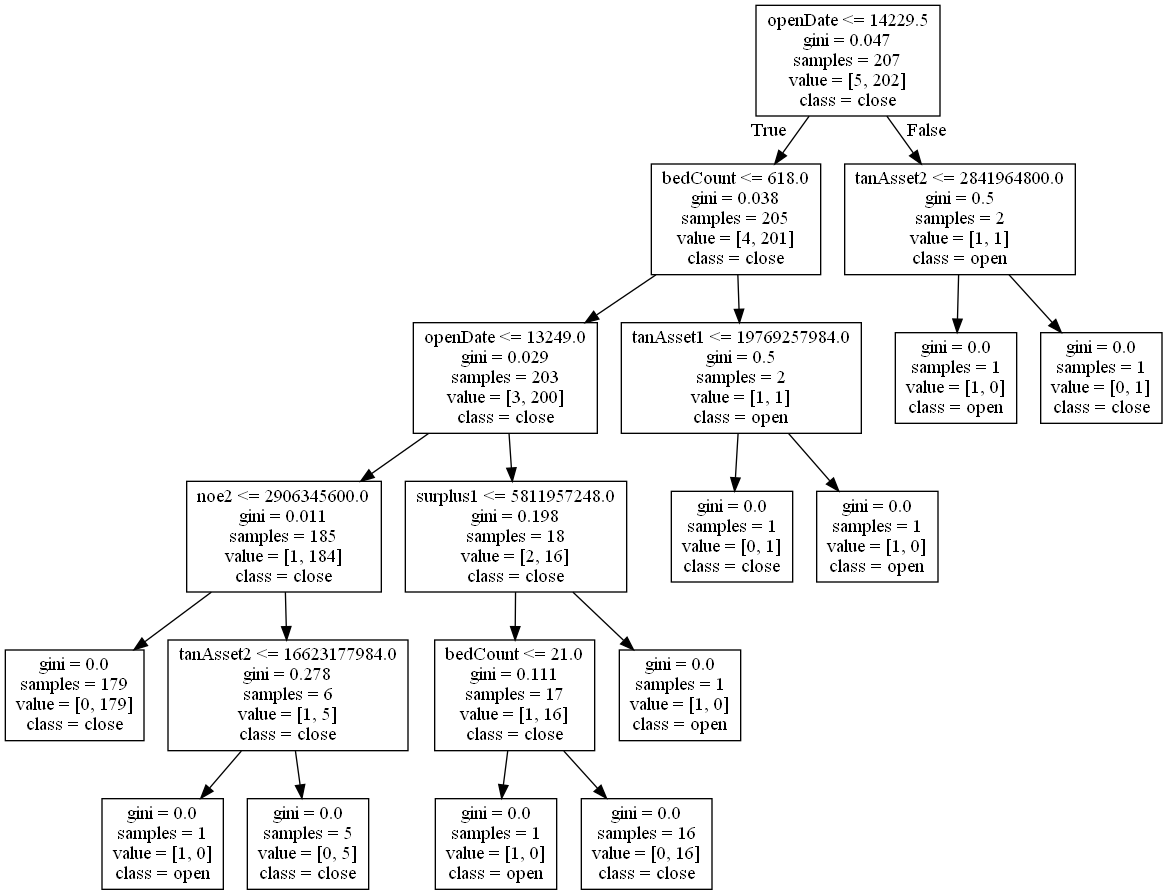

In [12]:
# 의사결정 나무 그래프 이미지 파일을 출력
from io import BytesIO
from PIL import Image
Image.open(BytesIO(data))

In [13]:
# 앞에서 이미 테스트 정확도를 출력했으니 굳이 이걸 또 할 필요는 없음
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test, dt_prediction)
# print("정확도 :", str(accuracy*100)+"%")

### 3. test.csv 데이터에 대한 병원 개폐업 예측

In [14]:
# 진짜 테스트 데이터인 test.csv 파일 불러오고 앞에서 했던 것과 같이 사본 생성
test = pd.read_csv("test.csv",sep=",",dtype='unicode',thousands = ',')
F = test.copy()
# fillna(n) : 빈칸을 n으로 채우기
# https://www.delftstack.com/ko/howto/python-pandas/how-to-replace-all-the-nan-values-with-zeros-in-a-column-of-a-pandas-dataframe/
# OC에 값이 없기 때문에 dropna() 메소드 적용 시 모든 데이터가 없어지는 것을 방지하는 목적으로 OC의 데이터를 0으로 채움
F.OC = F.OC.fillna(0)
F.OC

0      0
1      0
2      0
3      0
4      0
      ..
122    0
123    0
124    0
125    0
126    0
Name: OC, Length: 127, dtype: int64

In [15]:
# 앞에서 했던 것과 동일한 방법으로 F의 데이터 전처리
F = F.dropna().copy()

F.sido.replace(['choongnam', 'gyeongnam', 'gyeonggi', 'incheon', 'busan',\
       'jeonnam', 'seoul', 'jeonbuk', 'choongbuk', 'ulsan', 'daejeon',\
       'daegu', 'gyeongbuk', 'gangwon', 'gwangju', 'sejong','jeju'],
                   [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],inplace=True)
F.instkind.replace(['nursing_hospital', 'general_hospital', 'hospital',\
       'traditional_clinic', 'clinic', 'traditional_hospital',\
       'dental_clinic'], [1,2,3,4,5,6,7],inplace=True)
F.ownerChange.replace(['same', 'change'],[0,1],inplace=True)

F.employee1 = F.employee1.str.replace(',', '').astype('int')
F.employee2 = F.employee2.str.replace(',', '').astype('int')

F["openDate"] = (pd.to_datetime(F["openDate"])-pd.to_datetime("1978-01-24")).dt.days


In [16]:
# 앞서 했던 방법과 똑같이 z를 정의
# 마찬가지로 자료형을 int로 하려 했으나 숫자가 너무 큰 관계로 float 자료형으로 변환
z = np.array(pd.DataFrame(F, columns = ['sido', 'sgg', 'openDate', 'bedCount', 'instkind',
       'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2', 'ownerChange'])).astype(float)
z

array([[4.0000e+00, 1.3900e+02, 7.6100e+03, ..., 6.9300e+02, 6.9300e+02,
        0.0000e+00],
       [1.7000e+01, 1.4900e+02, 1.3924e+04, ..., 3.7900e+02, 3.7100e+02,
        0.0000e+00],
       [5.0000e+00, 7.1000e+01, 1.1721e+04, ..., 7.6000e+02, 7.6000e+02,
        0.0000e+00],
       ...,
       [1.0000e+00, 1.5900e+02, 1.2298e+04, ..., 1.9000e+01, 1.9000e+01,
        0.0000e+00],
       [9.0000e+00, 1.6500e+02, 5.6200e+03, ..., 4.9000e+01, 4.0000e+01,
        0.0000e+00],
       [3.0000e+00, 1.7700e+02, 1.2134e+04, ..., 1.1100e+02, 1.1100e+02,
        0.0000e+00]])

In [18]:
# 앞에서 훈련한 결과를 바탕으로 z에 대한 예측값 출력
# test_clf = dtc()
# test_clf = test_clf.fit(x_train,y_train)
test_prediction = dt_clf.predict(z)
test_prediction

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [22]:
# submission_sample.csv 파일에 결과값을 붙여넣으려 했으나
# 처음에 NaN이 있는 row를 모두 제거했기 때문에 row 개수가 맞지 않아 실패
submission = pd.read_csv("submission_sample.csv",sep=",",dtype='unicode')
submission.OC = test_prediction
submission

ValueError: Length of values (102) does not match length of index (127)